In [1]:
import glob
import os
import csv
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from tabulate import tabulate
from astropy.table import Table
from astropy.io import ascii
from matplotlib.lines import Line2D
import matplotlib.ticker as tck
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from astropy.visualization import (MinMaxInterval, PercentileInterval, ImageNormalize, ZScaleInterval,simple_norm, LinearStretch, SqrtStretch, LogStretch, AsinhStretch)
import matplotlib as mpl
mpl.rcParams['errorbar.capsize'] = 2
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams["font.family"] = "serif"

In [3]:
fits.open('fit_outs/binned_nebular_specs_ESO113-32_MUSE.binned.lines.fits').info()

Filename: fit_outs/binned_nebular_specs_ESO113-32_MUSE.binned.lines.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  DATA          1 PrimaryHDU      79   ()      
  1  FLUX          1 ImageHDU        51   (9724, 1, 41)   float64   
  2  EFLUX         1 ImageHDU        10   (9724, 1, 41)   float64   
  3  VEL           1 ImageHDU        10   (9724, 1, 41)   float64   
  4  EVEL          1 ImageHDU        10   (9724, 1, 41)   float64   
  5  LINEPARS      1 ImageHDU        10   (9724, 1, 123)   float64   
  6  ELINEPARS     1 ImageHDU        10   (9724, 1, 164)   float64   
  7  FLUXINT       1 ImageHDU        10   (9724, 1, 41)   float64   


In [2]:
PLANE1 = 'NII_6548.05'
PLANE2 = 'Halpha_6562.77'
PLANE3 = 'NII_6583.45'
PLANE10 = 'Hbeta_4861.33'
PLANE13 = 'OIII_5007'
PLANE20 = 'HeI_5875'
PLANE24 = 'OI_6300'
PLANE27 = 'SII_6716'
PLANE28 = 'SII_6731'


header = fits.open('fit_outs/binned_nebular_specs_NGC863_MUSE.binned.lines.fits')[1].header
header
plane_names = [PLANE1,PLANE2,PLANE3,PLANE10,PLANE13,PLANE20,PLANE24,PLANE27,PLANE28]
planes = [0, 1, 2, 9, 12, 19, 23, 26, 27]
wls = [6548.05, 6562.77, 6583.45, 4861.33, 5007, 5875, 6300, 6716, 6731]

galaxies = list(ascii.read('TABLE_MASTER_edge_on.tsv')['galaxy'])

# <font color='blue'>Lines</font>

In [3]:
galaxies = ['ESO157-49']
for gal in galaxies:
    print(gal)
    bin_map = fits.open('seg_maps/seg_adabin_SNSII_10_'+gal+'.fits')[0].data
    
    line_map = np.zeros((bin_map.shape[0], bin_map.shape[1]))
    e_line_map = np.zeros((bin_map.shape[0], bin_map.shape[1]))
    vel_map = np.zeros((bin_map.shape[0], bin_map.shape[1]))
    e_map = np.zeros((bin_map.shape[0], bin_map.shape[1]))
    i_plane = 0
    
    for plane in planes:
        flux = fits.open('fit_outs/ALT_binned_nebular_specs_'+gal+'_MUSE.binned.lines.fits')[1].data[plane]
        e_flux = fits.open('fit_outs/ALT_binned_nebular_specs_'+gal+'_MUSE.binned.lines.fits')[2].data[plane]
        vel = fits.open('fit_outs/ALT_binned_nebular_specs_'+gal+'_MUSE.binned.lines.fits')[3].data[plane]#[5].data[3*plane+2]*299792.458/wls[i_plane]
        e_vel = fits.open('fit_outs/ALT_binned_nebular_specs_'+gal+'_MUSE.binned.lines.fits')[4].data[plane]#[6].data[3*plane+2]*299792.458/wls[i_plane]
        
        for bin_index in range(0, int(np.max(bin_map))):
            coords = np.where(bin_map == bin_index)
            x, y = list(coords[0]), list(coords[1])
            for i,j in zip(x,y):    
                line_map[int(i),int(j)] = flux[0, bin_index]
                e_line_map[int(i),int(j)] = e_flux[0, bin_index]/2
                vel_map[int(i),int(j)] = vel[0, bin_index]
                e_map[int(i),int(j)] = e_vel[0, bin_index]/2
        
        hdu_flux = fits.PrimaryHDU(line_map)
        hdu_error = fits.ImageHDU(e_line_map ,name='errores')
        hdu_new = fits.HDUList([hdu_flux, hdu_error])
        hdu_new.writeto('line_maps/binned_flux_' +gal+'_'+plane_names[i_plane] + '.fits', overwrite=True)
        
        hdu_vel = fits.PrimaryHDU(vel_map)
        hdu_e_vel = fits.ImageHDU(e_map ,name='errores')
        hdu_new = fits.HDUList([hdu_vel, hdu_e_vel])
        hdu_new.writeto('vel_maps/binned_vel_' + gal+'_'+plane_names[i_plane] + '.fits', overwrite=True)
        i_plane=i_plane+1


IC217
PGC28308
PGC30591
ESO544-27
IC1553
ESO443-21
ESO469-15
ESO157-49


# <font color='green'>EWs</font>

In [7]:
for gal in galaxies:
    print(gal)

    bin_map = fits.open('seg_maps/seg_adabin_SNSII_10_'+gal+'.fits')[0].data
    
    EW_Ha_map = np.zeros((bin_map.shape[0], bin_map.shape[1]))
    e_EW_Ha_map = np.zeros((bin_map.shape[0], bin_map.shape[1]))
    EW_Hb_map = np.zeros((bin_map.shape[0], bin_map.shape[1]))
    e_EW_Hb_map = np.zeros((bin_map.shape[0], bin_map.shape[1]))
        
    EW_Ha = fits.open('/home/raul/Doctorado/BETISII/fit_outs/ALT_binned_stellar_specs_'+gal+'_MUSE.EWs.binned.fits')[2].data[0]
    e_EW_Ha = fits.open('/home/raul/Doctorado/BETISII/fit_outs/ALT_binned_stellar_specs_'+gal+'_MUSE.EWs.binned.fits')[3].data[0]
    EW_Hb = fits.open('/home/raul/Doctorado/BETISII/fit_outs/ALT_binned_stellar_specs_'+gal+'_MUSE.EWs.binned.fits')[2].data[1]
    e_EW_Hb = fits.open('/home/raul/Doctorado/BETISII/fit_outs/ALT_binned_stellar_specs_'+gal+'_MUSE.EWs.binned.fits')[3].data[1]
    
    for bin_index in range(0, int(np.max(bin_map))):
        coords = np.where(bin_map == bin_index)
        x, y = list(coords[0]), list(coords[1])
        for i,j in zip(x,y):    
            EW_Ha_map[int(i),int(j)] = EW_Ha[0, bin_index]
            e_EW_Ha_map[int(i),int(j)] = e_EW_Ha[0, bin_index]/2
            EW_Hb_map[int(i),int(j)] = EW_Hb[0, bin_index]
            e_EW_Hb_map[int(i),int(j)] = e_EW_Hb[0, bin_index]/2
    
    hdu_flux = fits.PrimaryHDU(EW_Ha_map)
    hdu_error = fits.ImageHDU(e_EW_Ha_map ,name='errores')
    hdu_new = fits.HDUList([hdu_flux, hdu_error])
    hdu_new.writeto('EW_maps/binned_EW_Ha_' +gal+'.fits', overwrite=True)
    
    hdu_flux = fits.PrimaryHDU(EW_Hb_map)
    hdu_error = fits.ImageHDU(e_EW_Hb_map ,name='errores')
    hdu_new = fits.HDUList([hdu_flux, hdu_error])
    hdu_new.writeto('EW_maps/binned_EW_Hb_' +gal+'.fits', overwrite=True)

UGC8896
ESO163-G11
ESO443-21
ESO113-32
NGC3157
ESO467-51
IC1498
IC719
UGC10738
NGC4666
IC1657
NGC259
UGC11037
UGC2936
ESO297-G37
ESO234-19
NGC5690
UGC11723
UGC9450


In [2]:
"""""

For aesthetic reasons, you can take the binned maps and divide the flux of every bin with 
the number of pixels than contains the bin for doing some nice plots.

"""""
def divide_flux(seg_map, maps):

    for i in range(1,int(np.max(seg_map)+1)):
        x_ = np.where(seg_map==i)[0]
        y_ = np.where(seg_map==i)[1]
        if len(x_)>0:
            maps[x_,y_] = maps[x_,y_] / np.sqrt(len(x_))
    return maps

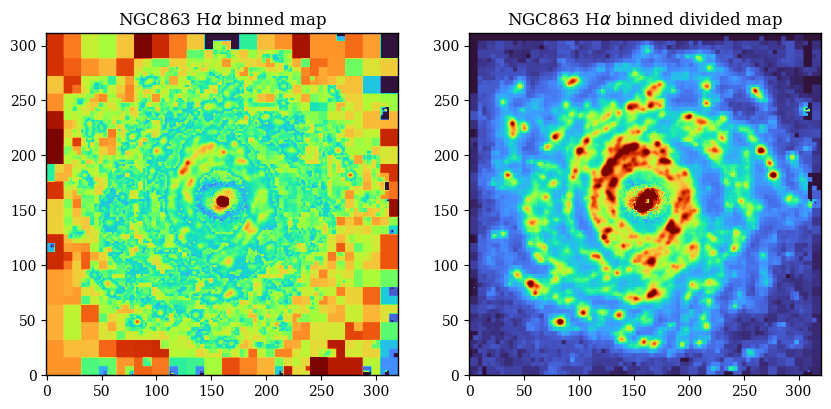

In [30]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize = (10,8))

Interval=PercentileInterval(98.5)

binned_ha_map = fits.open('binned_NGC863_MUSE.binned.lines_Ha.fits')[1].data[1]

divided_binned_ha_map = fits.open('NGC863_divided_Ha.fits')[0].data

norm = ImageNormalize(binned_ha_map,Interval,stretch=SqrtStretch())

ax.imshow(binned_ha_map ,origin='lower',norm=norm, cmap='turbo')

norm2 = ImageNormalize(divided_binned_ha_map,Interval,stretch=SqrtStretch())

ax2.imshow(divided_binned_ha_map ,origin='lower',norm=norm2, cmap='turbo')

ax.set_title(r'NGC863 H$\alpha$ binned map')
ax2.set_title(r'NGC863 H$\alpha$ binned divided map')


plt.show()